In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from scipy.signal import find_peaks, savgol_filter
from scipy.special import wofz
import scipy.stats
from scipy.optimize import curve_fit
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut

In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
def combined_gaussian(x, *params):
    N = len(params) // 3
    result = np.zeros_like(x)
    for i in range(N):
        mu, sigma, amplitude = params[i*3:(i+1)*3]
        result += amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)
    return result

def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)


def combined_pseudo_voigt(x, *params):
    N = len(params) // 4
    result = np.zeros_like(x)
    for i in range(N):
        mu, sigma, amplitude, eta = params[i*4:(i+1)*4]
        gaussian_term = amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)
        lorentzian_term = (1.0 - eta) * (sigma / ((x - mu)**2 + sigma**2))
        result += eta * gaussian_term + lorentzian_term
    return result

def pseudo_voigt(x, mu, sigma, amplitude, eta):
    gaussian_term = amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)
    lorentzian_term = (1.0 - eta) * (sigma / ((x - mu)**2 + sigma**2))
    result = eta * gaussian_term + lorentzian_term
    return result

In [5]:
def read_gauss(gauss_file, sample_file, show_plot=True):
    """
    Reads gauss files containing peak info and creates a plot and calculates
    area of each peak.
    """
    
    gauss = pd.read_csv(gauss_file)
    sample = pd.read_csv(sample_file, header=None)
    domain = sample[0].to_numpy()
    sample = sample[1]
    
    y_peaks = []
    peak_areas = []
    
    for index, row in gauss[['wavenumber', 'sigma', 'amplitude']].iterrows():
        y_pred = gaussian(domain, *row)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)
    y_peaks_sum = y_peaks.sum(axis=0)

    print(len(y_peaks))
    
    integral = np.trapz(y_peaks_sum, x=domain)
    
    normalization_factor = 100 / integral
    y_peaks_sum_norm = y_peaks_sum * normalization_factor
    
    # Plot the normalized curve
    plt.plot(domain, y_peaks_sum_norm, color='k')
    plt.xlim([950, 1700])
    
    # Plot each individual peak
    for peak in y_peaks:
        # Normalize each peak and plot it
        peak_normalized = peak * normalization_factor
        plt.plot(domain, peak_normalized, linestyle='--', alpha=0.5)
        
        # Calculate the area under each normalized peak
        peak_area = np.trapz(peak_normalized, x=domain)
        peak_areas.append(peak_area)
    
    gauss['area'] = np.array(peak_areas, dtype=np.float32)

    if show_plot:
        plt.show()
    
    return gauss

def read_pseudo_voigt(voigt_file, sample_file, show_plot=True):
    """
    Reads gauss files containing peak info and creates a plot and calculates
    area of each peak.
    """
    
    voigt = pd.read_csv(voigt_file)
    sample = pd.read_csv(sample_file, header=None)
    domain = sample[0].to_numpy()
    sample = sample[1]
    
    y_peaks = []
    peak_areas = []
    
    for index, row in voigt[['wavenumber', 'sigma', 'amplitude', 'eta']].iterrows():
        y_pred = pseudo_voigt(domain, *row)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)
    y_peaks_sum = y_peaks.sum(axis=0)

    print(len(y_peaks))
    
    integral = np.trapz(y_peaks_sum, x=domain)
    
    normalization_factor = 100 / integral
    y_peaks_sum_norm = y_peaks_sum * normalization_factor
    
    # Plot the normalized curve
    plt.plot(domain, y_peaks_sum_norm, color='k')
    plt.xlim([1000, 1700])
    
    # Plot each individual peak
    for peak in y_peaks:
        # Normalize each peak and plot it
        peak_normalized = peak * normalization_factor
        plt.plot(domain, peak_normalized, linestyle='--', alpha=0.5)
        
        # Calculate the area under each normalized peak
        peak_area = np.trapz(peak_normalized, x=domain)
        peak_areas.append(peak_area)
    
    voigt['area'] = np.array(peak_areas, dtype=np.float32)

    if show_plot:
        plt.show()
    
    return voigt

In [6]:
pd.options.display.float_format = '{:.3f}'.format

23


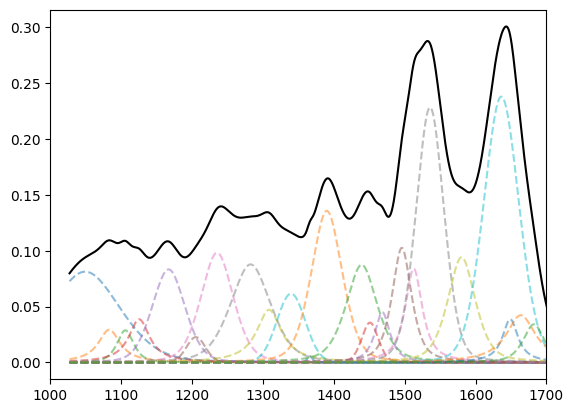

,wavenumber,sigma,amplitude,eta,peak,area
0,1048.950,50.844,0.594,0.099,1049.585,7.136
1,1082.888,18.719,0.000,0.485,1081.888,1.532
2,1105.621,12.892,0.013,0.785,1105.030,1.035
3,1125.175,17.915,0.000,0.350,1125.761,2.029
4,1166.706,23.927,0.106,0.568,1167.706,5.193
5,1205.280,13.425,0.021,1.000,1206.276,0.764
6,1235.155,23.847,0.196,0.327,1234.721,6.209
7,1282.427,29.877,0.774,0.066,1283.416,7.021
8,1308.480,21.391,0.001,0.054,1307.522,3.037
9,1339.548,19.997,0.058,1.000,1339.342,3.088


In [7]:
read_pseudo_voigt("fit/gauss/gauss_0_5.8.csv", "fit/sample/sample_0_5.8.csv")

24


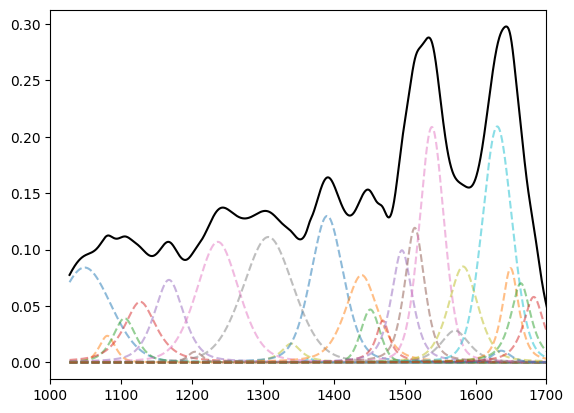

,wavenumber,sigma,amplitude,eta,peak,area
0,1048.120,38.270,0.130,0.559,1049.103,5.838
1,1080.203,11.931,0.016,0.885,1079.959,0.752
2,1104.586,17.694,0.029,0.631,1105.512,1.879
3,1126.695,25.241,0.233,0.074,1125.761,3.720
4,1167.204,22.327,0.193,0.192,1168.188,4.447
5,1203.849,10.600,0.007,0.975,1204.829,0.266
6,1236.194,31.112,1.590,0.048,1235.203,8.737
7,1307.492,36.737,0.906,0.096,1308.486,10.613
8,1339.855,16.632,0.001,0.739,1338.860,0.836
9,1365.825,4.472,0.001,0.985,1366.823,0.055


In [8]:
read_pseudo_voigt("fit/gauss/gauss_181_8.27.csv", "fit/sample/sample_4_5.36.csv")

<Axes: >

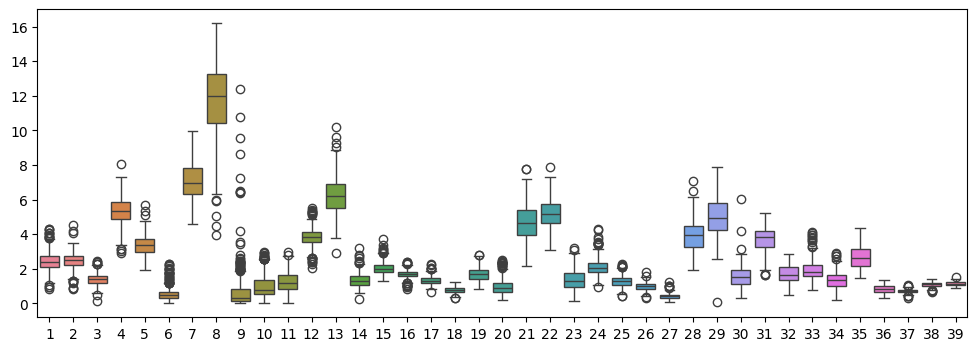

In [9]:
areas = pd.read_csv("areas.csv")
areas = areas.iloc[:, 1:]
areas = areas.reset_index(drop=True)
plt.figure(figsize=(12, 4))
sns.boxplot(data=areas.iloc[:, 1:])

In [10]:
df = pd.read_csv("../data/dataset.csv")
df = df.reset_index(drop=True)
hba1c = df['HbA1c']

areas_hba1c = areas.copy()
areas_hba1c['HbA1c'] = hba1c
areas_hba1c

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,HbA1c
0,1.270,2.242,2.905,1.181,5.187,3.691,0.410,6.753,11.508,2.194,...,3.011,1.009,2.489,1.354,1.949,1.066,0.724,1.142,1.094,5.800
1,1.086,2.659,1.903,2.149,4.799,3.948,0.455,7.882,11.529,0.142,...,4.338,0.699,2.309,1.476,2.070,1.059,0.829,1.207,1.210,5.080
2,1.005,2.805,2.616,1.258,5.790,2.841,0.585,6.289,12.909,1.108,...,3.525,1.630,1.782,2.093,1.892,1.210,0.517,1.172,1.046,7.500
3,1.187,2.532,2.500,1.217,5.152,3.223,0.680,6.147,13.541,0.104,...,2.967,1.939,2.024,0.547,3.481,0.366,0.578,1.185,1.044,4.460
4,1.814,1.701,2.527,1.458,5.700,3.394,0.435,6.258,15.502,0.104,...,3.815,1.259,1.296,1.636,2.908,0.683,0.843,1.001,1.231,5.360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0.673,3.325,2.608,1.167,5.706,3.070,0.533,6.863,13.025,0.212,...,3.319,2.387,2.739,0.771,1.978,0.983,0.756,1.009,1.308,9.000
409,0.785,2.472,2.333,1.212,5.489,2.854,0.057,8.979,7.605,0.620,...,4.053,2.083,2.860,1.992,2.088,0.605,0.887,0.665,1.201,6.500
410,1.509,2.741,3.007,0.734,5.404,2.636,0.560,6.077,6.449,10.782,...,4.118,1.695,2.610,0.412,2.665,0.577,0.808,0.872,1.261,9.700
411,0.861,2.685,2.484,1.245,5.330,3.337,0.455,5.714,14.442,0.087,...,4.318,2.333,1.474,1.748,2.742,0.630,0.740,1.094,1.172,7.200


In [11]:
# for col in range(len(areas.columns)):
#     area = areas_hba1c.iloc[:, col]
#     hba1c = areas_hba1c['HbA1c']
#     plt.scatter(area, hba1c)
#     plt.show()

R: 0.036302270508307054, p value: 0.4618792956028188, RMSE: 1.7385767521321986


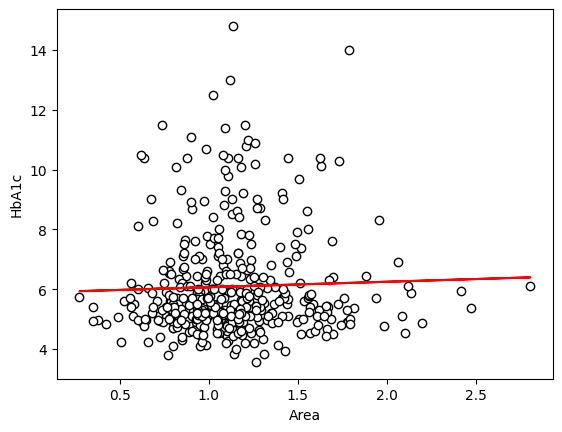

R: -0.08219569959980245, p value: 0.09528099957338623, RMSE: 1.7338366199742095


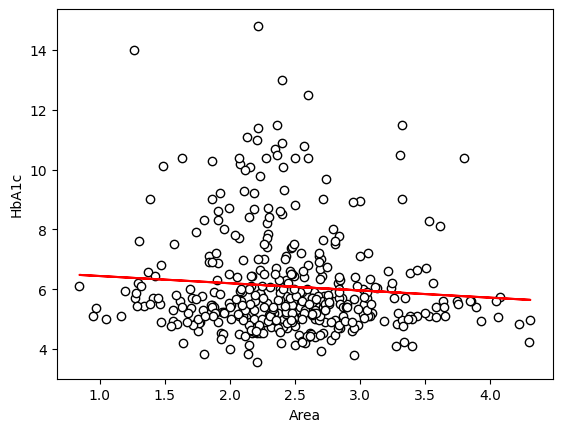

R: 0.06727424355137657, p value: 0.17238610474704869, RMSE: 1.7357821760919279


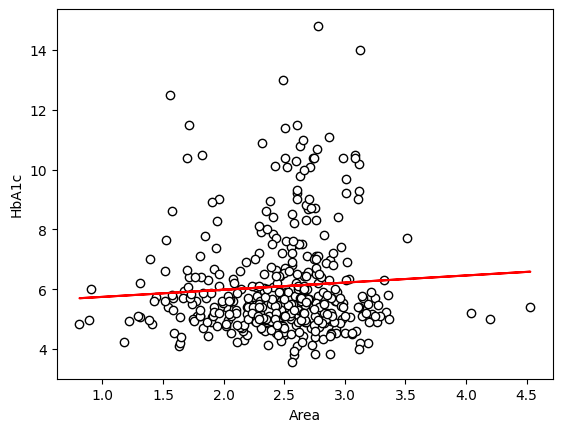

R: 0.09402836544718708, p value: 0.05622048766431379, RMSE: 1.7320156691549993


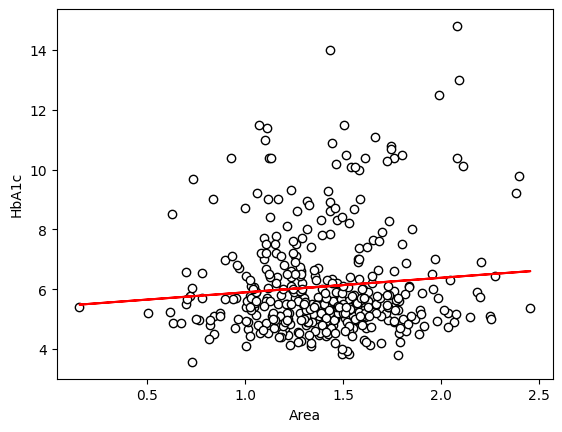

R: 0.04974982383389359, p value: 0.3131683102049222, RMSE: 1.7375692008325618


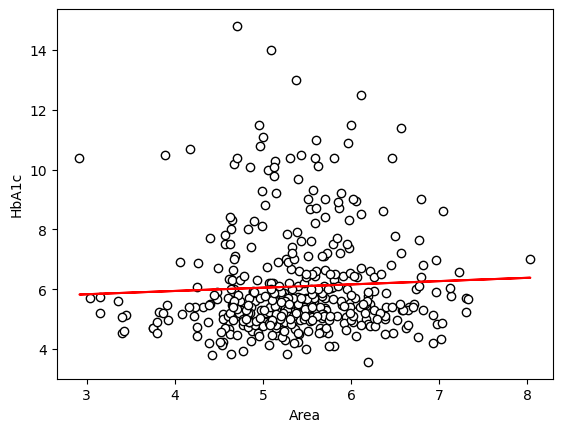

R: -0.04851868586580144, p value: 0.325308723457173, RMSE: 1.73767456580853


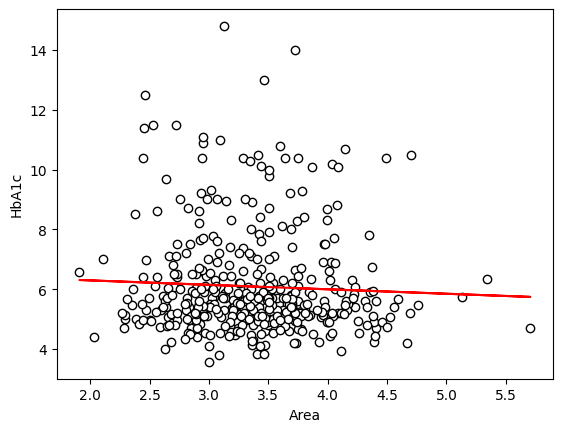

R: 0.07959177373213751, p value: 0.10627674717479456, RMSE: 1.7342042828231838


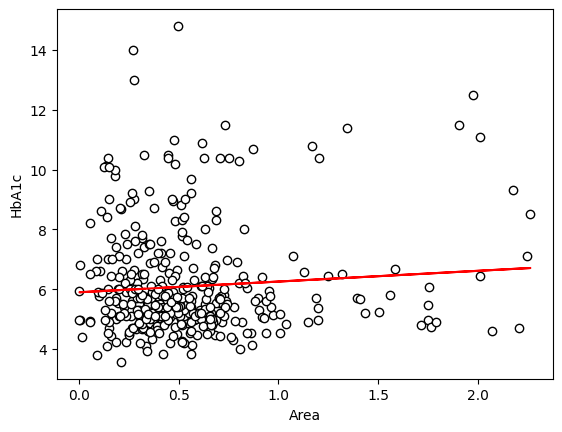

R: -0.042951961813658714, p value: 0.38394896431954273, RMSE: 1.738117958013278


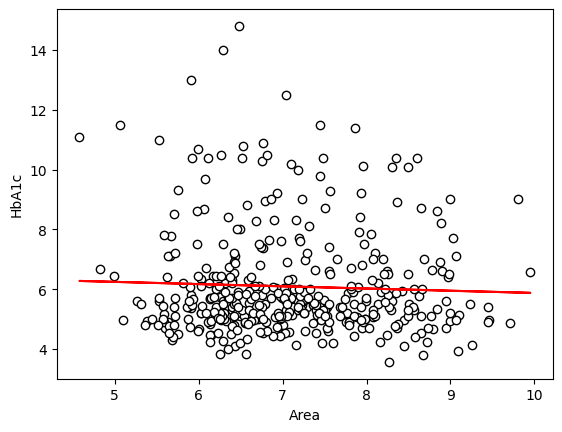

R: -0.15793713591006248, p value: 0.001281158935096743, RMSE: 1.7178885059398041


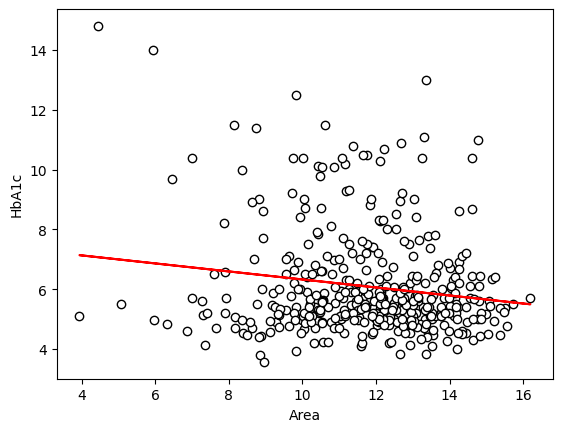

R: 0.20598950478454486, p value: 2.4555944623657115e-05, RMSE: 1.7024137211355368


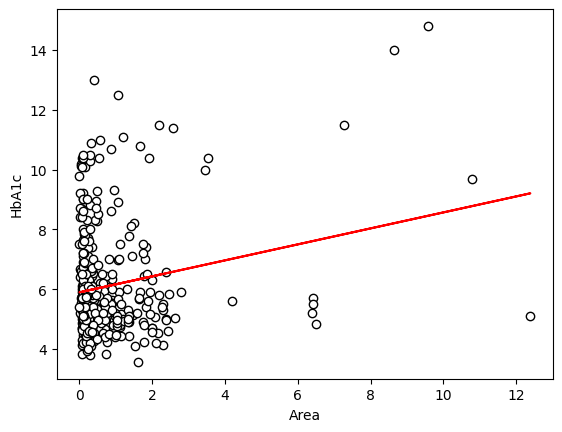

R: 0.05758085004626076, p value: 0.2429667607473033, RMSE: 1.7368370131959807


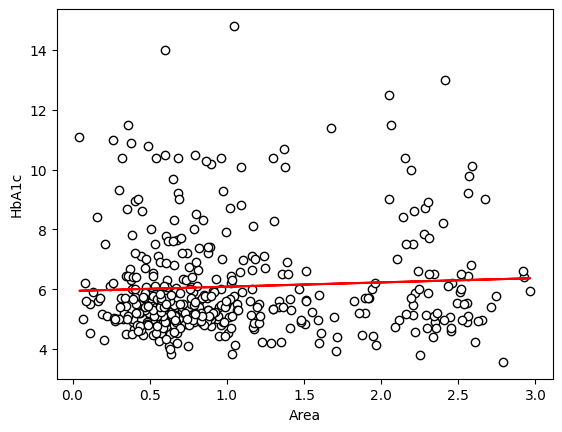

R: -0.007927070979843886, p value: 0.8723994915418952, RMSE: 1.7396688199452566


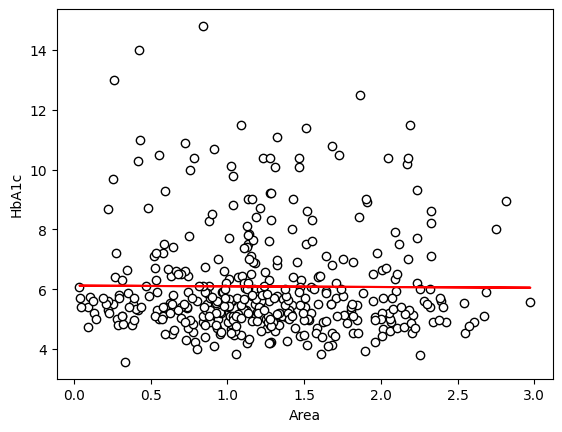

R: -0.12752351020835628, p value: 0.00947756730954769, RMSE: 1.7255195927720404


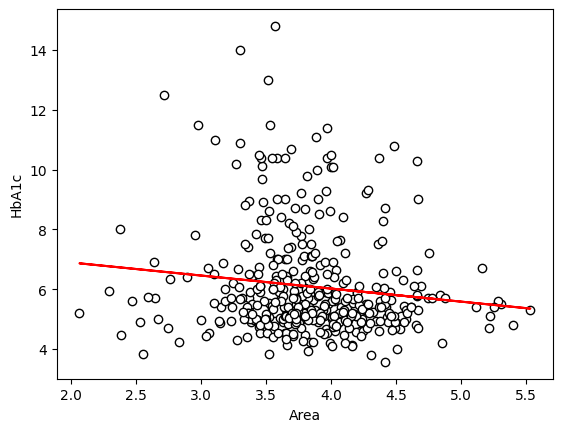

R: 0.06358701297878736, p value: 0.19717929255748942, RMSE: 1.7362028000400767


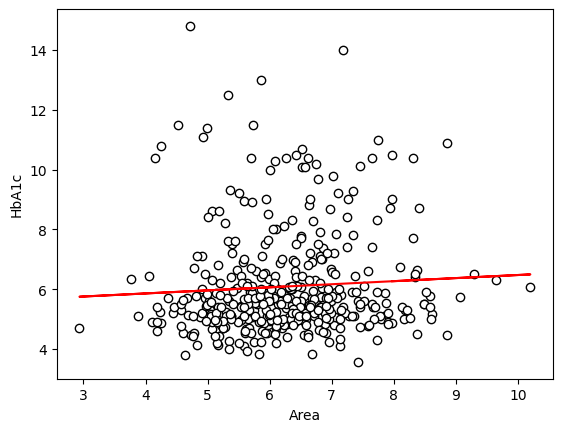

R: -0.10847804756773086, p value: 0.02749893347927154, RMSE: 1.7294571032692072


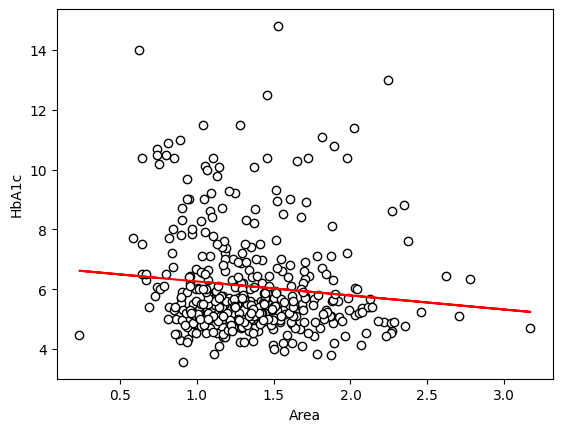

R: 0.21803255351564438, p value: 7.770066859654894e-06, RMSE: 1.6978683390071003


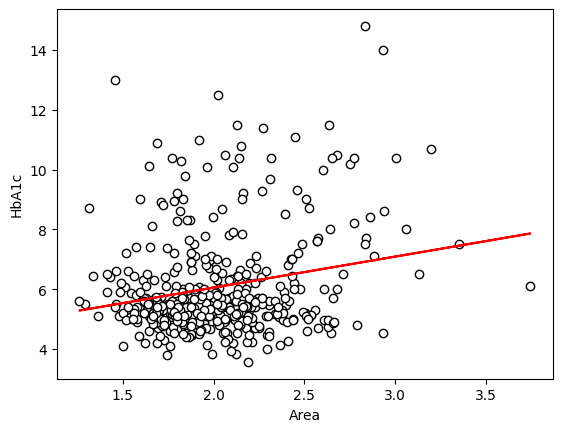

R: -0.34215553879477434, p value: 8.724480704063544e-13, RMSE: 1.6347195651867241


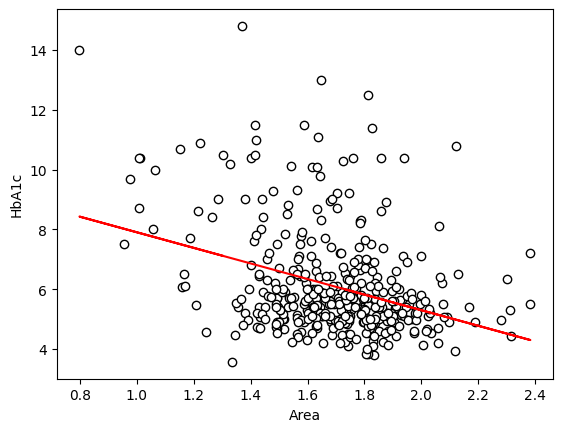

R: 0.0317564614513365, p value: 0.5198517943026353, RMSE: 1.7388460283499685


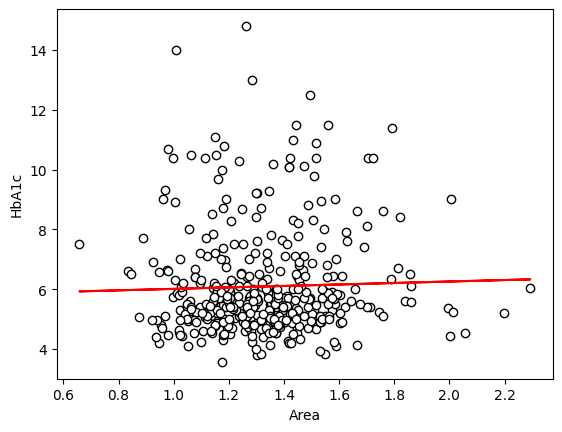

R: -0.15947975253440716, p value: 0.0011458550586106047, RMSE: 1.7174571080145669


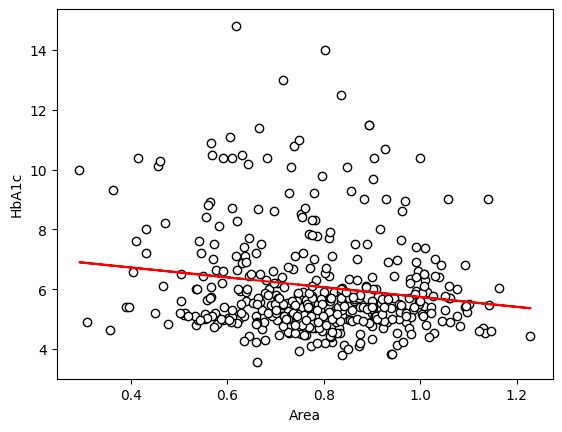

R: -0.06730349660624986, p value: 0.17219915404328043, RMSE: 1.7357787438324186


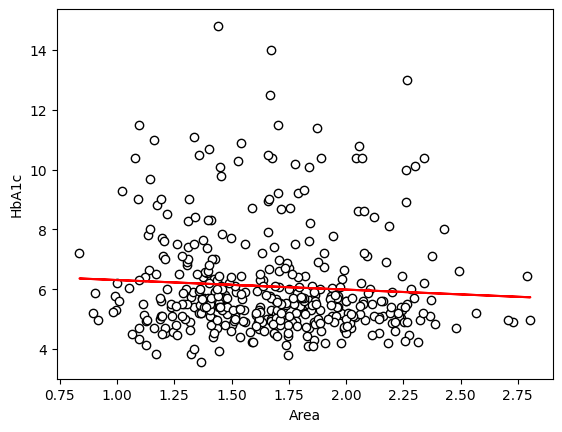

R: 0.2060710945337281, p value: 2.43706373152879e-05, RMSE: 1.7023838352696


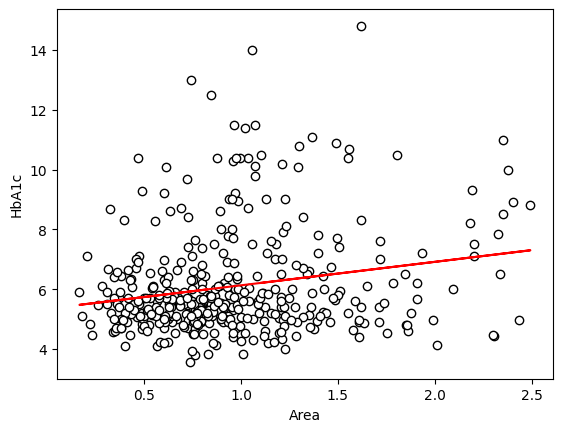

R: 0.08020207438948045, p value: 0.10361365006105361, RMSE: 1.7341191798466755


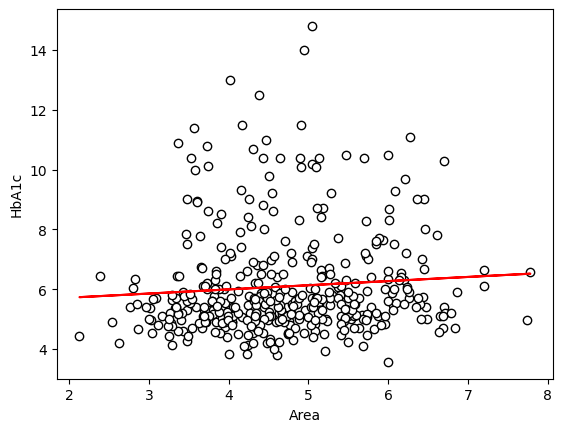

R: -0.07554347753557374, p value: 0.12533432892866414, RMSE: 1.7347522371594766


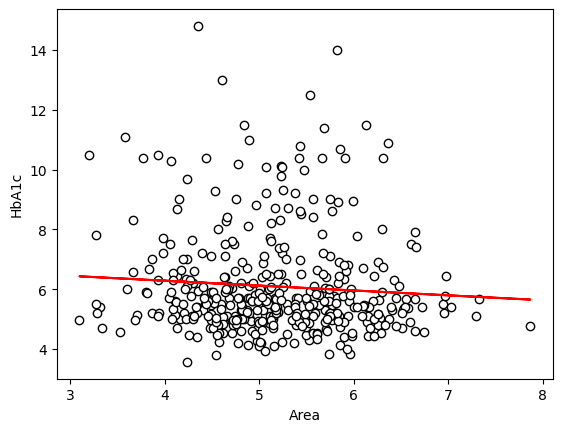

R: -0.12103094272999008, p value: 0.01384582550858057, RMSE: 1.7269343130604293


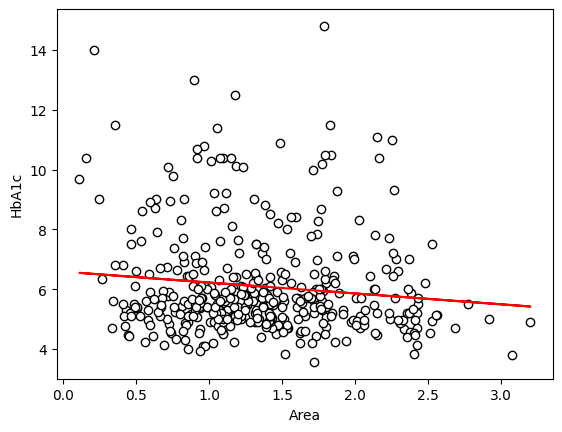

R: 0.08257195169736761, p value: 0.09377008821514685, RMSE: 1.7337825096742712


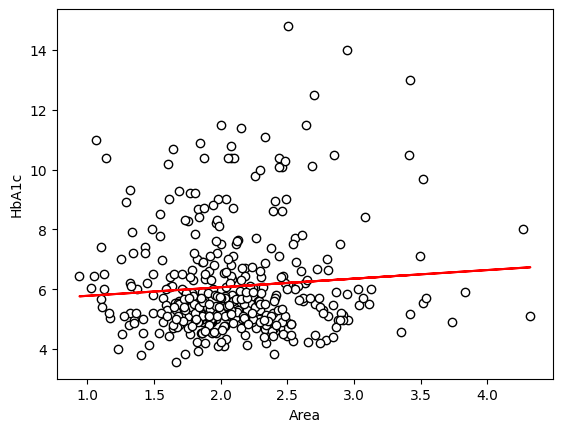

R: 0.03204690471373363, p value: 0.516039161685099, RMSE: 1.7388299005087298


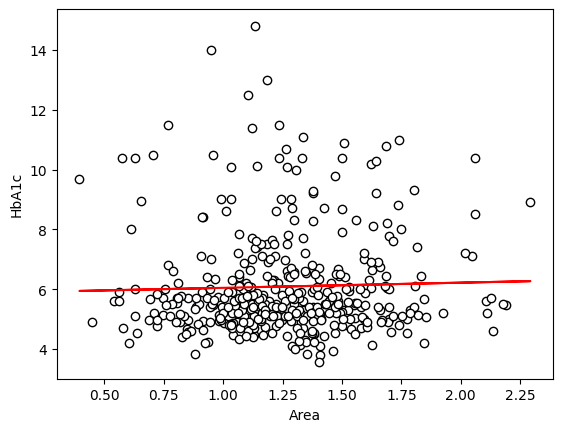

R: 0.0752308268918662, p value: 0.12691002346624822, RMSE: 1.7347933591863054


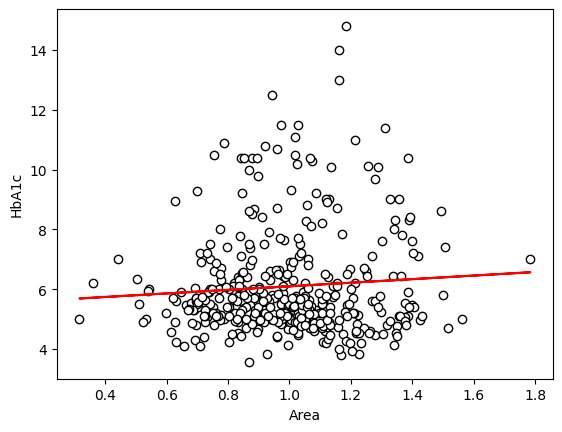

R: 0.03860163685377337, p value: 0.43398425618097014, RMSE: 1.7384268292383738


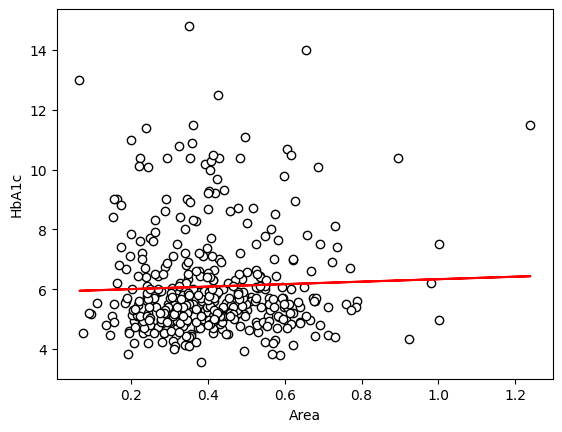

R: -0.05540631199989142, p value: 0.2612507762209076, RMSE: 1.7370510757673931


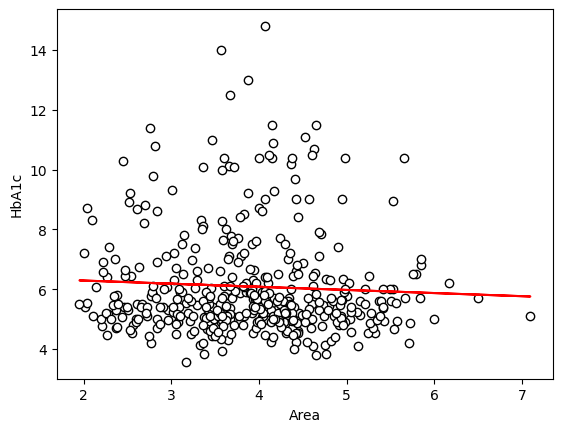

R: -0.10918081416679669, p value: 0.026505237822649463, RMSE: 1.7293232512481775


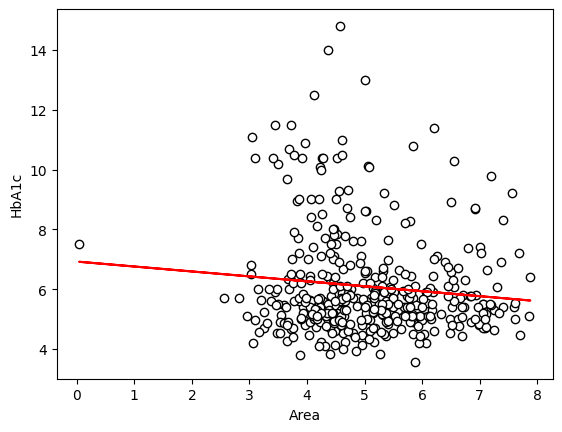

R: 0.014804855703820832, p value: 0.7641964025038898, RMSE: 1.739532811562307


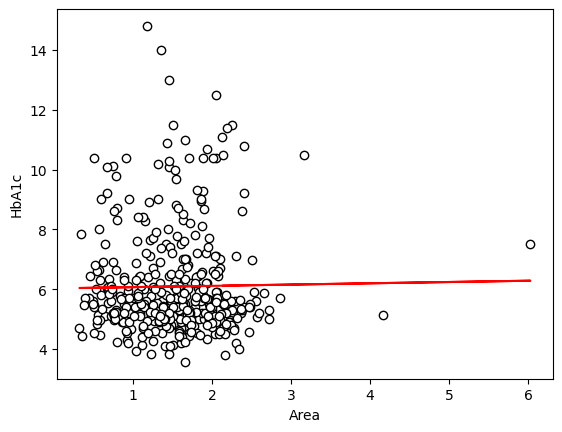

R: -0.03924928505947083, p value: 0.4263059806989764, RMSE: 1.73838293753372


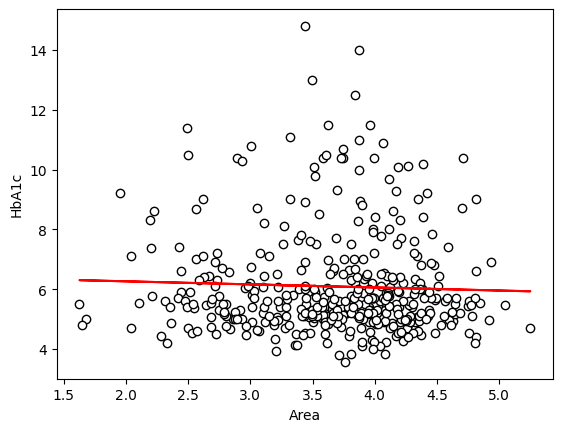

R: 0.10701184664272498, p value: 0.029675587827563188, RMSE: 1.7297335467478654


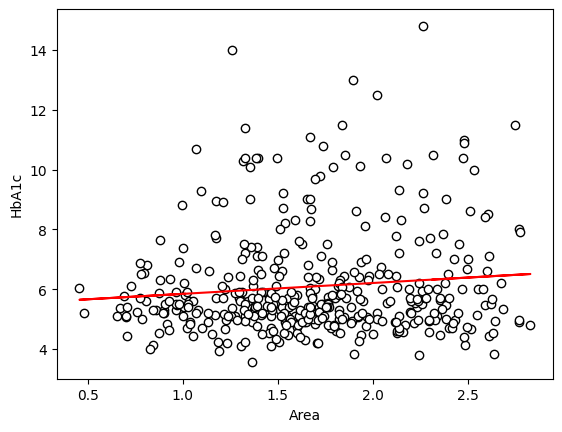

R: 0.19709397228521675, p value: 5.509041809825222e-05, RMSE: 1.7055981115176857


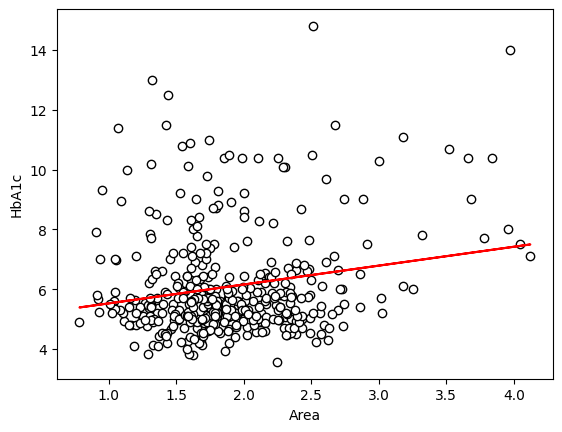

R: -0.056875309173936454, p value: 0.24879818803858045, RMSE: 1.7369073728894446


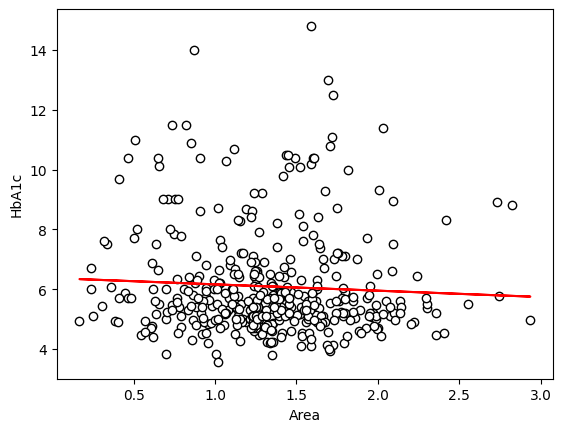

R: 0.12210948494979783, p value: 0.013015815132316609, RMSE: 1.7267044983306195


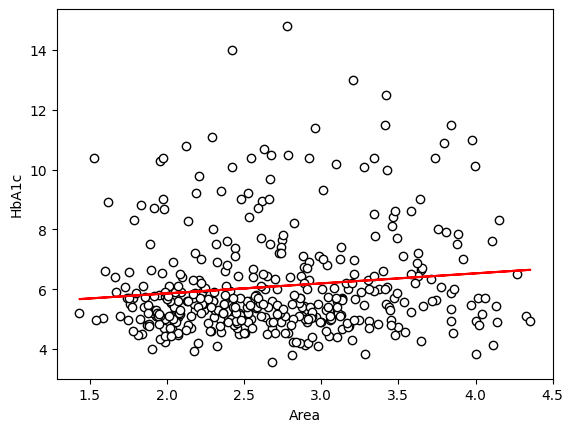

R: -0.18894236212270993, p value: 0.00011201488396554593, RMSE: 1.7083878937200518


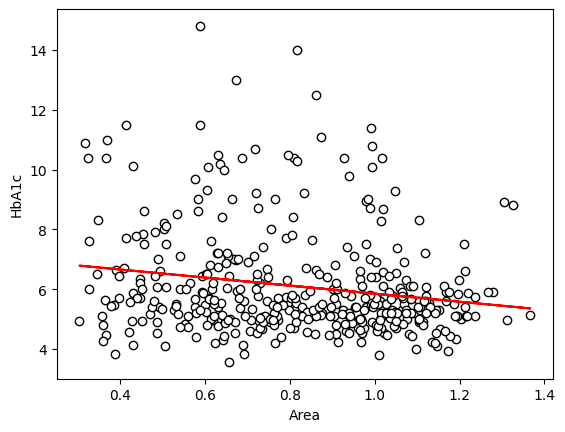

R: 0.02585155367809628, p value: 0.6003752906167568, RMSE: 1.739142053351516


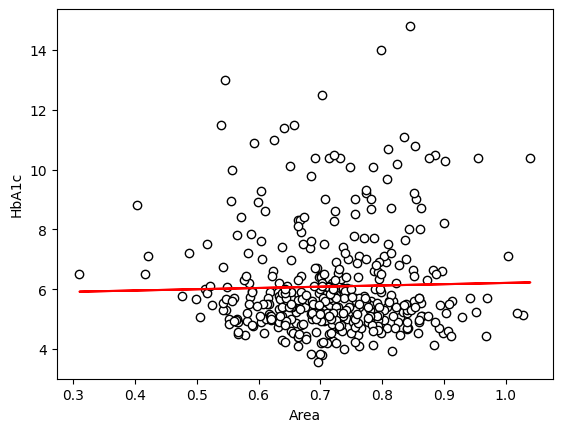

R: -0.3104368827789716, p value: 1.120461141600872e-10, RMSE: 1.65377069315159


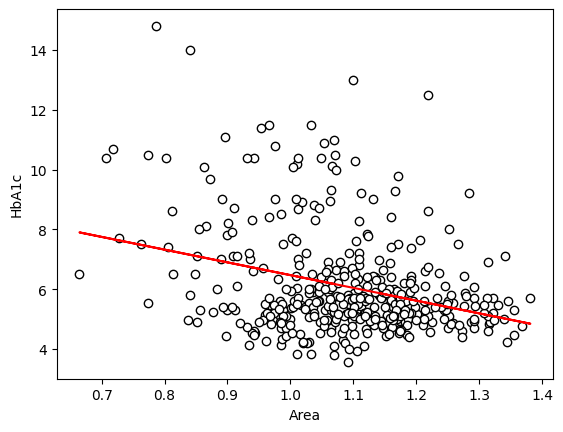

R: 0.113723958946931, p value: 0.020797347864093426, RMSE: 1.7284368271788602


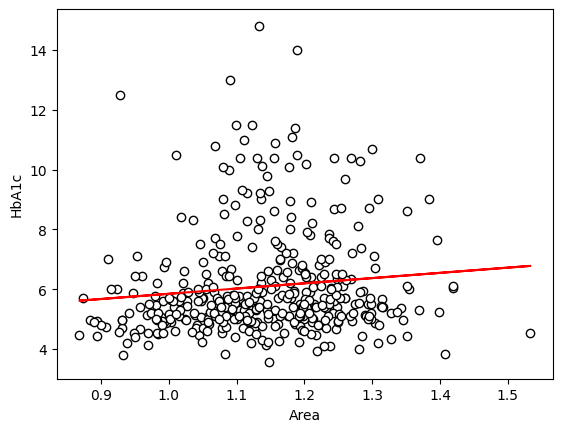

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

for col in range(len(areas.columns)):
    # Get the area and HbA1c columns
    area = areas_hba1c.iloc[:, col]
    hba1c = areas_hba1c['HbA1c']
    
    area_reshaped = np.array(area).reshape(-1, 1)
    hba1c_reshaped = np.array(hba1c).reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(area_reshaped, hba1c_reshaped)
    
    hba1c_pred = model.predict(area_reshaped)
    
    slope, intercept, r_value, p_value, std_err = linregress(area, hba1c)
    
    mse = mean_squared_error(hba1c, hba1c_pred)
    print(f"R: {r_value}, p value: {p_value}, RMSE: {np.sqrt(mse)}")

    plt.scatter(area, hba1c, facecolor='w', edgecolor='k')
    plt.plot(area, hba1c_pred, color='red')
    plt.xlabel('Area')
    plt.ylabel('HbA1c')
    plt.show()

In [13]:
from analysis import *

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 2.0001             │
│ R2 = -0.3217              │
│ R = -0.0185               │
│ Number of components = 17 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='Sample', ylabel='Residuals'>]], dtype=object))

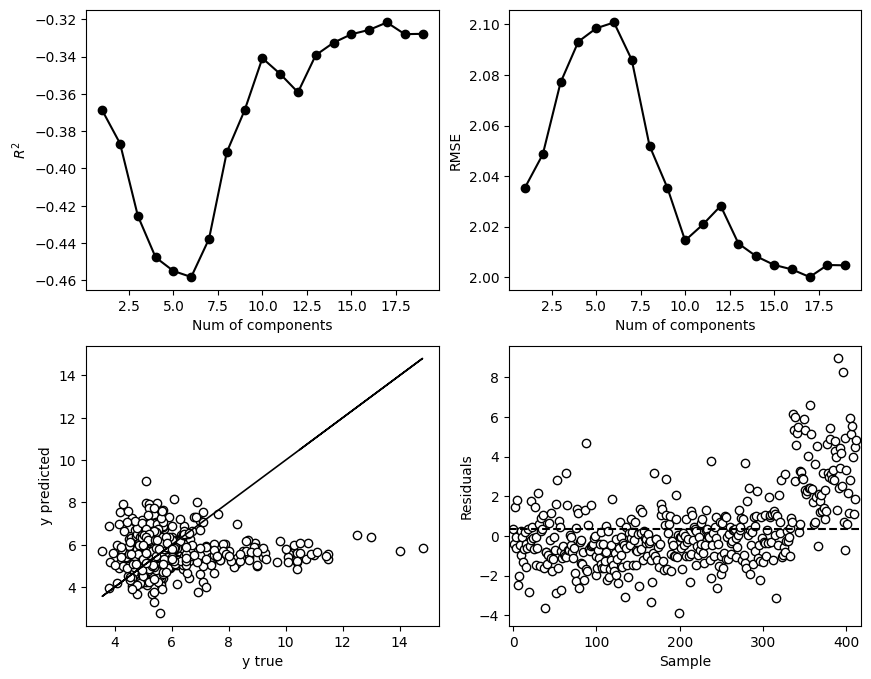

In [14]:
plot_number_components(areas, hba1c, cv=5)